In [29]:
import praw 
import prawcore
import pandas as pd
import datetime as dt
import networkx as nx
from networkx.algorithms import bipartite
import requests
import json
import sys
import traceback
import time
import matplotlib.pyplot as plt

In [2]:
client_id = "rax4hz8_P0_ttyt8crPYEg"
client_secret = "7zKse44yWl7Dge7kYQV6fKs20IzLdw"
user_agent = "data_analysis_crypto_sentiment v1.0 by /u/K_C_7"

reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

#api = PushshiftAPI(reddit)

#### Some preliminary, superficial work. 

Extracting daily discussions from the largest crypto subreddit, namely 'r/cryptocurrency'.

In [ ]:
start_time = int(dt.datetime(2017, 7, 17).timestamp())
end_time = int(dt.datetime(2021, 8, 1).timestamp())

daily_discussions = api.search_submissions(q='"Daily Discussion -"', after=start_time, before=end_time, subreddit='Cryptocurrency')

In [ ]:
daily_discussions = list(daily_discussions)

In [ ]:
discussions = []
for post in daily_discussions:
    discussions.append([post.title, post.author, post.score, post.id, post.subreddit, post.url,\
                        post.num_comments, post.selftext,\
                        dt.datetime.fromtimestamp(post.created).strftime("%Y-%m-%d %H:%M:%S")])
discussions = pd.DataFrame(discussions,columns=['title', 'author', 'score', 'id', 'subreddit', 'url',\
                                                'num_comments','body', 'created'])

In [ ]:
discussions.to_csv("r_cryptocurrency_daily_discussions.csv")

In [ ]:
popular_crypto_subs = ('bitcoin+btc+CryptoMarkets+bitcoinbeginners+CryptoCurrencies+'
                       'altcoin+'
                       'icocrypto+'
                       'CryptoCurrencyTrading+'
                       'Crypto_General+'
                       'ico+'
                       'blockchain+'
                       'Best Altcoin Subreddits+'
                       'ethereum+'
                       'Ripple+'
                       'litecoin+'
                       'Monero+'
                       'Stellar+'
                       'binance+'
                       'CoinBase+'
                       'ledgerwallet+'
                       'defi')

### Network Analysis

Extract data from dedicated cryptocurrency subreddits and their participators. Attempt to connect them via a graph in a meaningiful way and analyse the results. Some links for you if interested in Network Science.

https://towardsdatascience.com/an-intro-to-graph-theory-centrality-measurements-and-networkx-1c2e580adf37
http://networksciencebook.com
https://networkx.org/documentation/stable/tutorial.html

In [47]:
start_time = int(dt.datetime(2020, 3, 9).timestamp()) #define a window for reddit data extraction
end_time = int(dt.datetime(2020, 3, 16).timestamp())

Code adapted from: 
https://medium.com/web-mining-is688-spring-2021/how-influencers-on-reddit-form-a-network-of-related-subreddits-30884134c137

In [12]:
def get_posts(subred_name, limit):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=limit): 
        
        #extract submission data from subreddit   
        subred_info = []
        subred_info.append(subm.id)
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score','upvote_ratio',\
                                                    'num_comments', 'subreddit'])
    return posts_df



def get_user_posts(user, limit):
    redditor = reddit.redditor(user)
    redditor_subs = redditor.submissions.top(limit=limit) #get top (limit) submissions from user 
    posts_info = []
    
    for subm in redditor_subs:
        
        #extract submission information from user
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
        
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score','upvote_ratio',\
                                                    'num_comments', 'subreddit'])
    return posts_df      

Build a dataframe containing the extracted data

In [4]:
limit = 500
crypto_df = get_posts("cryptocurrency", limit)

In [5]:
print(crypto_df.shape)
crypto_df.head()

(500, 6)


,id,author,score,upvote_ratio,num_comments,subreddit
0,p9f4r4,zippyteach,6479,0.92,871,CryptoCurrency
1,q06h0r,zippyteach,6239,0.94,569,CryptoCurrency
2,mtsq3g,ziggyzago,6762,0.91,1835,CryptoCurrency
3,liodvr,ziggyzago,5454,0.96,232,CryptoCurrency
4,p1fkcr,yellao23,12652,0.78,3253,CryptoCurrency


In [6]:
freq_authors = crypto_df[crypto_df.duplicated(['author'], keep = False)] #remove duplicates
freq_authors = freq_authors[freq_authors.author != 'None'] #remove empty rows 
freq_authors.author.nunique() #number of unique authors in the subreddit

50

Text(0, 0.5, 'Number of posts')

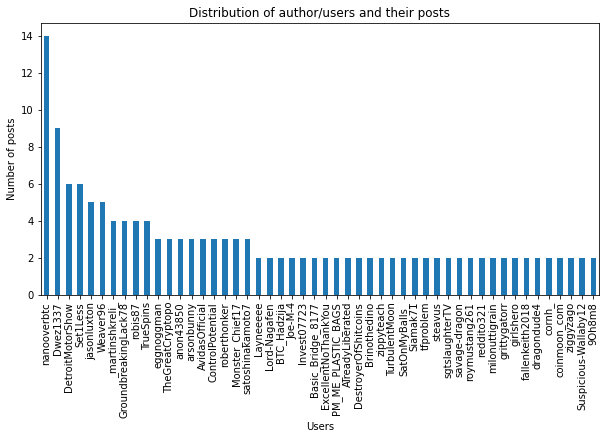

In [7]:
plt.figure(figsize=(10, 5))
ax = freq_authors['author'].value_counts().plot(kind='bar',\
                                                title='Number of posts each author makes in the r/CryptoCurrency subreddit')
ax.set_xlabel("Users")
ax.set_ylabel("Number of posts")

In [15]:
authors_lst = list(freq_authors.author.unique()) #list of unique authors

authors_df =  pd.DataFrame() 
authors_df = authors_df.fillna(0)
for u in authors_lst: 
    try:
        c = get_user_posts(u, limit=10)
    except prawcore.exceptions.Forbidden as e: #avoid the 403 Forbidden error 
        exc = e
        print(exc, user)
        
    authors_df = pd.concat([authors_df, c])

received 403 HTTP response
received 403 HTTP response
received 403 HTTP response


In [16]:
authors_df #num rows = limit*(number of unique authors)

,id,author,score,upvote_ratio,num_comments,subreddit
0,p9f4r4,zippyteach,6479,0.92,871,CryptoCurrency
1,q06h0r,zippyteach,6238,0.94,569,CryptoCurrency
2,q1ausc,zippyteach,1168,0.92,455,CryptoCurrency
3,pab7du,zippyteach,1061,0.97,264,CryptoCurrency
4,occfqm,zippyteach,1030,0.98,309,houston
...,...,...,...,...,...,...
5,onzuar,9Oh8m8,1854,0.98,310,CryptoCurrency
6,oylbhu,9Oh8m8,1753,0.97,554,CryptoCurrency
7,7f2r0a,9Oh8m8,1585,0.96,142,PUBATTLEGROUNDS
8,6unh8b,9Oh8m8,1222,0.94,218,soccer


Text(0, 0.5, 'Number of contributions')

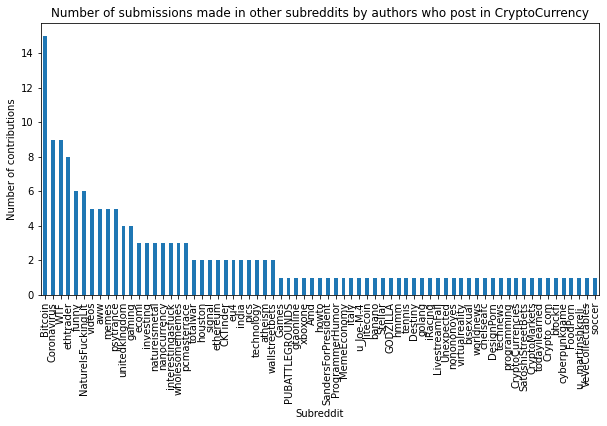

In [53]:
subreddit_counts = authors_df.subreddit.value_counts()
plt.figure(figsize=(10, 5))
ax = subreddit_counts[1:].plot(kind='bar',\
                           title='Number of submissions made in other subreddits by authors who post in CryptoCurrency')
ax.set_xlabel("Subreddit")
ax.set_ylabel("Number of contributions")

We can see that without much filtering, we are picking up trends that authors who post in CryptoCurrency also post in other financially related subreddits. Here Bitcoin is leading the pack. The appearance of Coronavirus here is intriguing too... it is left to a deeper search to find out more on what is being discussed in said subreddits.

For a first step, we now draw a graph connecting the authors and subreddits. We will form a graph $g$ containing nodes $V$ and edges $E$. Nodes $r,s \in V$ will be joined by an edge $e$ iff redditor $r$ has made a submission in subreddit $s$. A fact we shall verify is that this graph is ${\bf bipartite}$. The nodes of a bipartite graph can be split into two disjoint sets $R$ and $S$ such that the edges of the graph only connect nodes from $R$ to nodes in $S$. In particular, you will find no link between any two nodes of the same set. In this example $R$ is the set of submission authors and $S$ is the set of subreddits. Conceptually, the nodes of the graph split into two distinct categories, and we only form links <b> between </b> categories. 

In [20]:
nx_df = authors_df[['author', 'subreddit']]
nx_df.head()

,author,subreddit
0,zippyteach,CryptoCurrency
1,zippyteach,CryptoCurrency
2,zippyteach,CryptoCurrency
3,zippyteach,CryptoCurrency
4,zippyteach,houston


In [46]:
g = nx.from_pandas_edgelist(nx_df, source='author', target='subreddit') #form graph from dataframe

In [32]:
print(nx.info(g))
bipartite.is_bipartite(g) #graph is bipartite 

Graph with 119 nodes and 139 edges


True

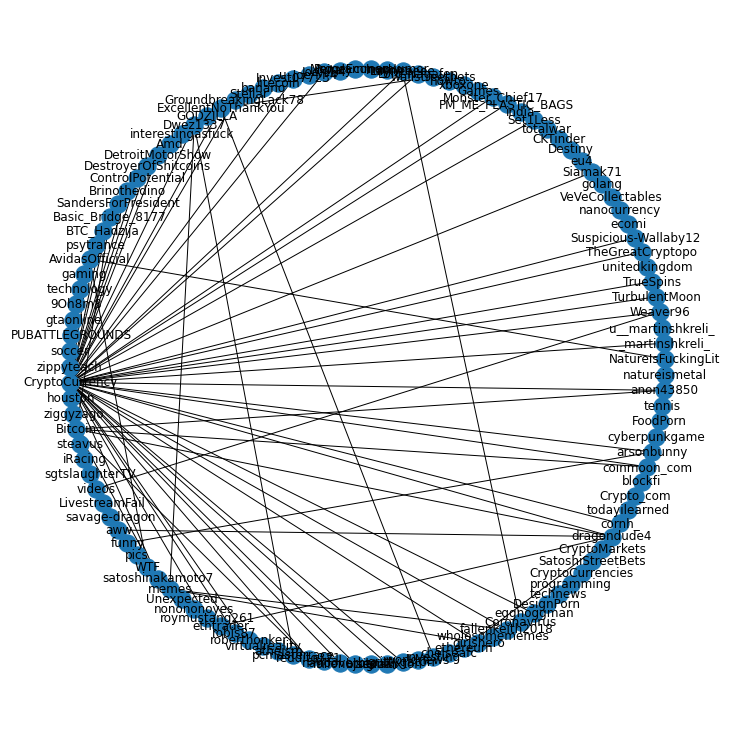

In [26]:
from matplotlib.pyplot import figure 
figure(figsize=(10,10))
nx.draw_shell(g,with_labels=True) #draw g with no filtering in a circular shape 

In [34]:
[authors, subreddits] = bipartite.sets(g) #verify this recovers authors and subreddits
G_authors = bipartite.projected_graph(g, authors)
G_subreddits = bipartite.projected_graph(g, subreddits)

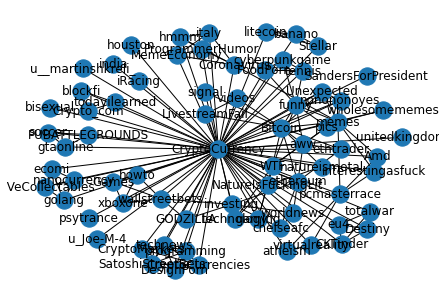

In [37]:
nx.draw(G_subreddits,with_labels=True)

The graph above is a <b> projection </b> of $g$ onto the set of subreddit nodes. In particular, any two subreddits $s, s'$ are linked by an edge iff $\exists\, r \in R$ such that $s \sim r$ and $s' \sim r$, where $a \sim b$ denotes the existence of an edge between $a$ and $b$. In layman's terms, if a redditor has posted in two different subreddits $s, s'$ then they will be linked on this projection. This is all analogous for the author projection. 

Draw a graph highlighting the importance of certain subreddits relative to each other and the authors of their submissions. Very naively, really just for demonstration, define an influencer (looking at the bar chart above) to be an author who has made submissions in at least five subreddits.

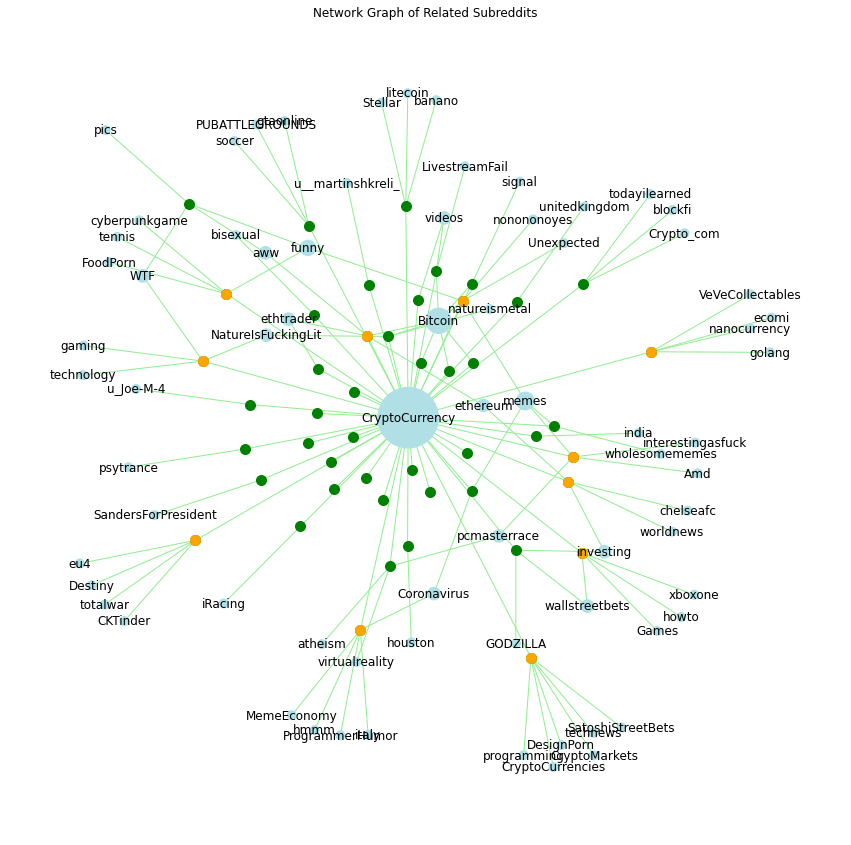

In [48]:
figure(figsize=(15,15))

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

sub_size = [g.degree(sub) * 80 for sub in subreddits] #multiplying by 80 to get circular size
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subreddits, 
                       node_size=sub_size, 
                       node_color='powderblue')
# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=authors, node_color='green', node_size=100)
# Draw highly connected influencers 
popular_people = [person for person in authors if g.degree(person) >= 5]  
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)
nx.draw_networkx_edges(g, layout, width=1, edge_color="lightgreen")
node_labels = dict(zip(subreddits, subreddits)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.show()

Author nodes appear green in color. Meanwhile, the subreddits appear in light blue and are sized according to their respective number of links. The 'influencers' who have more connections than just r/CryptoCurrency are highlighted in orange.

### Community Detection

In [65]:
#rename nodes in subreddit graph in a more convenient way
subreddit_nodes = list(G_subreddits.nodes())
subreddit_nodes_new = [sub.display_name for sub in subreddit_nodes]
mapping = dict(zip(subreddit_nodes, subreddit_nodes_new))
G_subreddits = nx.relabel_nodes(G_subreddits, mapping)

In [66]:
from networkx import community as com
import itertools
out1 = com.greedy_modularity_communities(G_subreddits)
print("modularity maximization, # of communities= ",len(out1))
print("modularity maximization, modularity= ", com.modularity(G_subreddits,out1))

modularity maximization, # of communities=  8
modularity maximization, modularity=  0.4857117262384663


In [69]:
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman
c = list(greedy_modularity_communities(G_subreddits))

In [70]:
c

[frozenset({'CryptoCurrency',
            'Crypto_com',
            'PUBATTLEGROUNDS',
            'SandersForPresident',
            'Stellar',
            'banano',
            'bisexual',
            'blockfi',
            'gtaonline',
            'houston',
            'iRacing',
            'india',
            'litecoin',
            'psytrance',
            'soccer',
            'todayilearned',
            'u_Joe-M-4',
            'u__martinshkreli_',
            'unitedkingdom'}),
 frozenset({'Bitcoin',
            'FoodPorn',
            'LivestreamFail',
            'NatureIsFuckingLit',
            'Unexpected',
            'WTF',
            'aww',
            'cyberpunkgame',
            'ethtrader',
            'funny',
            'gaming',
            'natureismetal',
            'nonononoyes',
            'pics',
            'signal',
            'technology',
            'tennis',
            'videos'}),
 frozenset({'GODZILLA',
            'Games',
            'chels

In [60]:
G_subreddits.nodes()

NodeView((Subreddit(display_name='WTF'), Subreddit(display_name='totalwar'), Subreddit(display_name='signal'), Subreddit(display_name='wallstreetbets'), Subreddit(display_name='SatoshiStreetBets'), Subreddit(display_name='CryptoCurrency'), Subreddit(display_name='todayilearned'), Subreddit(display_name='atheism'), Subreddit(display_name='cyberpunkgame'), Subreddit(display_name='VeVeCollectables'), Subreddit(display_name='banano'), Subreddit(display_name='virtualreality'), Subreddit(display_name='natureismetal'), Subreddit(display_name='psytrance'), Subreddit(display_name='Crypto_com'), Subreddit(display_name='funny'), Subreddit(display_name='ethtrader'), Subreddit(display_name='golang'), Subreddit(display_name='hmmm'), Subreddit(display_name='Coronavirus'), Subreddit(display_name='gtaonline'), Subreddit(display_name='pics'), Subreddit(display_name='CryptoMarkets'), Subreddit(display_name='chelseafc'), Subreddit(display_name='eu4'), Subreddit(display_name='MemeEconomy'), Subreddit(displ

---------------------

Note: if the problem is ever encountered, you can use 

```python
getattr('zippyteach', "is_suspended", False)
```

to identify a suspended user. 

--------------------- 

### Ignore (for now)

Below were (are) attempts to do various things but have been unsuccessful, the code could be useful later though.

In [ ]:
def recursive_node_adder(g, comment, parent_author):
    '''Recursively process comments and add them to the graph'''
    
    # Check if we have the node already in our graph
    if comment.author not in g.nodes:
        g.add_node(comment.author)
    # Create an edge between this comment author and the parent author
    g.add_edge(comment.author, parent_author)
    # Iterate through the comments
    for reply in comment.replies.list():
        if isinstance(reply, praw.models.MoreComments):
            continue
        # Recursively process this reply
        recursive_node_adder(g, reply, comment.author)
        
# Create a directed graph
g = nx.DiGraph()
subreddit = popular_crypto_subs
breadthCommentCount = 20
most_active_crypto = reddit.subreddit(popular_crypto_subs).search(query='sell',\
                                                                  time_filter='week', limit=None)
for post in most_active_crypto:
    #print (post.author, "-", post.title)
    # Check if we have the node already in our graph
    if post.author not in g.nodes:
        g.add_node(post.author)
    post.comment_limit = breadthCommentCount
    # Get the top few comments
    for comment in post.comments.list():
        # Skip MoreComment objects, which don't have authors
        if isinstance(comment, praw.models.MoreComments):
            continue
        # Recursively process this reply
        recursive_node_adder(g, comment, post.author)

https://www.jcchouinard.com/how-to-use-reddit-api-with-python/

In [ ]:
def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the pushshift api.
 
    data_type can be 'comment' or 'submission'
    The rest of the args are interpreted as payload.
 
    Read more: https://github.com/pushshift/api
    """
 
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    payload = kwargs
    request = requests.get(base_url, params=payload)
    return request.json()

In [ ]:
data_type="comment"     # give me comments, use "submission" otherwise
query="eth"        # Add your query
duration=""           # Select the timeframe. Epoch value or Integer + "s,m,h,d" (i.e. "second", "minute", "hour", "day")
size=1000               # maximum 1000 comments
sort_type="score"       # Sort by score (Accepted: "score", "num_comments", "created_utc")
sort="desc"             # sort descending
aggs="subreddit"        #"author", "link_id", "created_utc", "subreddit"

In [ ]:
data = get_pushshift_data(data_type=data_type, 
                          q=query, 
                          after=duration, 
                          size=size,
                          limit=limit)

In [ ]:
data = data.get("data")
author = []
subreddit = []
num_comments = []

for dictionary in data:
    author.append(dictionary.get("author"))
    subreddit.append(dictionary.get("subreddit"))
    num_comments.append(dictionary.get("num_comments"))

In [ ]:
len(author)

https://github.com/Watchful1/Sketchpad/blob/master/postDownloader.py

In [ ]:
username = ""  # put the username you want to download in the quotes
subreddit = "CryptoCurrency"  # put the subreddit you want to download in the quotes
# leave either one blank to download an entire user's or subreddit's history
# or fill in both to download a specific users history from a specific subreddit

filter_string = None
if username == "" and subreddit == "":
	print("Fill in either username or subreddit")
	sys.exit(0)
elif username == "" and subreddit != "":
	filter_string = f"subreddit={subreddit}"
elif username != "" and subreddit == "":
	filter_string = f"author={username}"
else:
	filter_string = f"author={username}&subreddit={subreddit}"

url = "https://api.pushshift.io/reddit/{}/search?limit=1000&sort=desc&{}&before="

start_time = datetime.utcnow()
end_date = dt.datetime(2021,11,1)


def downloadFromUrl(filename, object_type):
	print(f"Saving {object_type}s to {filename}")

	count = 0
	handle = open(filename, 'w')
	previous_epoch = int(start_time.timestamp())
	while previous_epoch > int(dt.datetime.timestamp(end_date)):
		new_url = url.format(object_type, filter_string)+str(previous_epoch)
		json_text = requests.get(new_url, headers={'User-Agent': "Post downloader by /u/Watchful1"})
		time.sleep(1)  # pushshift has a rate limit, if we send requests too fast it will start returning error messages
		try:
			json_data = json_text.json()
		except json.decoder.JSONDecodeError:
			time.sleep(1)
			continue

		if 'data' not in json_data:
			break
		objects = json_data['data']
		if len(objects) == 0:
			break

		for object in objects:
			previous_epoch = object['created_utc'] - 1
			count += 1
			if object_type == 'comment':
				try:
					handle.write(str(object['score']))
					handle.write(" : ")
					handle.write(datetime.fromtimestamp(object['created_utc']).strftime("%Y-%m-%d"))
					handle.write("\n")
					handle.write(object['body'].encode(encoding='ascii', errors='ignore').decode())
					handle.write("\n-------------------------------\n")
				except Exception as err:
					print(f"Couldn't print comment: https://www.reddit.com{object['permalink']}")
					print(traceback.format_exc())
			elif object_type == 'submission':
				if object['is_self']:
					if 'selftext' not in object:
						continue
					try:
						handle.write(str(object['score']))
						handle.write(" : ")
						handle.write(datetime.fromtimestamp(object['created_utc']).strftime("%Y-%m-%d"))
						handle.write("\n")
						handle.write(object['selftext'].encode(encoding='ascii', errors='ignore').decode())
						handle.write("\n-------------------------------\n")
					except Exception as err:
						print(f"Couldn't print post: {object['url']}")
						print(traceback.format_exc())

		print("Saved {} {}s through {}".format(count, object_type, datetime.fromtimestamp(previous_epoch).strftime("%Y-%m-%d")))

	print(f"Saved {count} {object_type}s")
	handle.close()




In [ ]:
downloadFromUrl("posts.txt", "submission")
downloadFromUrl("comments.txt", "comment")